 Understanding the usage of transfer learning 

Here we will use VGGNet trained on ImageNet dataset. 
We will keep all the conv layers the same except the final fully connected layer

Thus we are writing our own simple classifier for flowers using VGGNet as a fixed feature extractor for our images

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# test qand train directories

data_dir = '~/datasets/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [5]:
# VGG Net needs input to be 224x224

data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))


Num training images:  3130
Num test images:  540


In [6]:
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

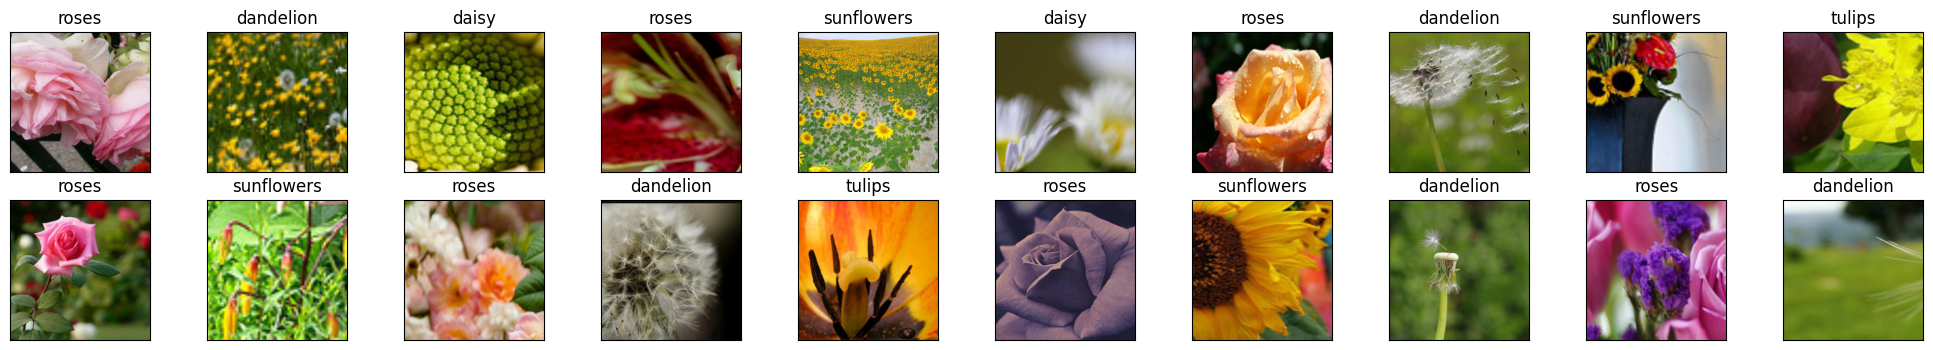

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
# Model

# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

print(vgg16)

/home/shankara/miniconda3/envs/deep-learning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shankara/miniconda3/envs/deep-learning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# last layer is -  (6): Linear(in_features=4096, out_features=1000, bias=True)

print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [10]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [12]:
# modify the last fully connected layer

import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# n_inputs -> 5
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()


print(vgg16.classifier[6].out_features)



5


In [13]:
# loss function

import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [14]:
# TRain:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
       
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # clear the gradients 
        optimizer.zero_grad()

        # forward pass
        output = vgg16(data)

        # loss
        loss = criterion(output, target)

        # backward pass
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

        torch.save(vgg16.state_dict(), './model_vgg.pt')

Epoch 1, Batch 20 loss: 1.5340785682201385
Epoch 1, Batch 40 loss: 1.3581648111343383
Epoch 1, Batch 60 loss: 1.2006245791912078
Epoch 1, Batch 80 loss: 1.1424603730440139
Epoch 1, Batch 100 loss: 1.0798598825931549
Epoch 1, Batch 120 loss: 0.9752901971340180
Epoch 1, Batch 140 loss: 0.9758601278066635
Epoch 2, Batch 20 loss: 0.8860297203063965
Epoch 2, Batch 40 loss: 0.8442340493202209
Epoch 2, Batch 60 loss: 0.8095400899648666
Epoch 2, Batch 80 loss: 0.8234722882509231
Epoch 2, Batch 100 loss: 0.7950423374772072
Epoch 2, Batch 120 loss: 0.7882388174533844
Epoch 2, Batch 140 loss: 0.7595491051673889


In [15]:
#  Test it

# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # forward pass
    output = vgg16(data)
    # loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.742275

Test Accuracy of daisy: 68% (63/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 67% (61/91)
Test Accuracy of sunflowers: 69% (70/101)
Test Accuracy of tulips: 69% (86/124)

Test Accuracy (Overall): 74% (402/540)


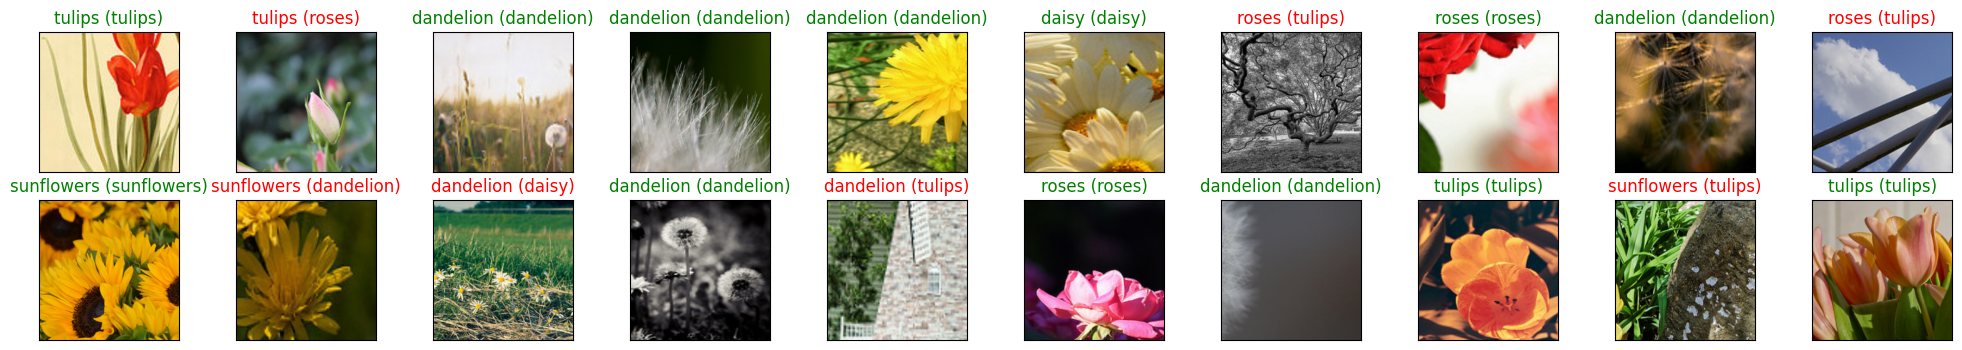

In [22]:
# visualize the results

dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))